### Cell 0: ( Only for Colab ) Install the git **repository**

In [ ]:
import sys
import os

# 1. Clone the repository
!git clone -b planning https://github.com/orc-podavini-grisenti/final_assignment

# 2. Point the project_root specifically to the cloned folder
# In Colab, the folder structure will be /content/final_assignment/
project_root = os.path.abspath('/content/final_assignment')

# 3. Add that specific folder to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


# 4. Link the Drive to the colab in order to store the results
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/final_assignment/outputs/models_saved"

# Crea la cartella se non esiste
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

Cloning into 'final_assignment'...
remote: Enumerating objects: 640, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 640 (delta 63), reused 134 (delta 48), pack-reused 480 (from 1)
Receiving objects: 100% (640/640), 34.74 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (237/237), done.
Mounted at /content/drive


### Cell 1: Imports & Setup Device

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from models.navigation_network import NavActor, NavCritic
from utils.normalization import ObservationNormalizer
from utils.reward_2 import NavigationReward

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### Cell 2: Setup Training Directory

In [2]:
EXPERIMENTS_PATH = drive_path if 'drive_path' in locals() else "experiments/"

# Global Output Directory
run_id = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
output_dir = os.path.join(EXPERIMENTS_PATH, run_id)
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

Results will be saved to: experiments/run_20260114_140802


### Cell 3: Enviroment Intialization

In [3]:
SEED = 0        # Seed for reproducibility

# MENAGE THE SEED for REPRODUCIBILITY 
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Seed set to: {SEED}")


# INIT THE ENVIROMENT 
env = UnicycleEnv()

# INIT THE REWARD CALCULATOR  
reward_calculator = NavigationReward(env.rob_cfg['v_max'], env.env_cfg['dt'])


def sample_seed(min_eval_seed=100):
    """Samples a seed, skipping the first 100 reserved for evaluation."""
    return random.randint(min_eval_seed, 1000000)

Seed set to: 0


### Cell 4: PPO Loss Implementation

In [4]:
# PPO Loss Hyperparameter
GAMMA = 0.99
EPSILON = 0.2
C1_VALUE_COEF = 0.5
C2_ENTROPY_COEF = 0.01

def ratio_function(log_prob_new, log_prob_old):
    """
    Calculates the probability ratio r_t(theta) for PPO. It computes the ratio between the new policy probability and the old 
    policy probability using log-probabilities for numerical stability.

    Formula:
        r_t(theta) = exp( log(pi_new) - log(pi_old) )
                   = pi_new / pi_old

    Args:
        log_prob_new (Tensor): Log-probability of the action under the current (updated) policy.
        log_prob_old (Tensor): Log-probability of the action under the old policy (from rollout buffer).

    Returns:
        Tensor: The probability ratio (importance sampling weight).
    """
    
    # 1. Subtract log-probabilities.
    # Mathematically equivalent to division in probability space: log(a/b) = log(a) - log(b).
    log_ratio = log_prob_new - log_prob_old
    
    # 2. Exponentiate to convert from log-space back to linear space (the actual ratio).
    ratio = torch.exp(log_ratio)
    
    return ratio



def calculate_returns(rewards):
    returns = []
    G_t = 0
    
    # Calculate Discounted Returns (Monte Carlo) backwards
    for step in reversed(range(len(rewards))):
        G_t = rewards[step] + GAMMA * G_t
        returns.insert(0, G_t)
    
    return returns



def calculate_advantages(returns, values):
    """
    Computes advantages (Returns - Values) using NumPy.
    """
    # Convert lists to numpy arrays
    returns_np = np.array(returns)
    values_np = np.array(values)
    
    # Element-wise subtraction
    advantages = returns_np - values_np
    
    return advantages



def calculate_surrogate_loss(
        new_log_probs,
        old_log_probs,
        epsilon,
        advantages):
    """
    Computes the PPO Clipped Surrogate Loss.
    
    Refers to the equation: 
    L_CLIP = E[ min( r_t * A_t, clip(r_t, 1-eps, 1+eps) * A_t ) ]
    """
    
    # 1. Detach advantages
    # We detach 'advantages' because they are constants calculated from the rollout.
    # We do NOT want to backpropagate gradients into the Critic through the Actor's loss.
    advantages = advantages.detach()

    # 2. Compute the probability ratio r_t(theta)
    # ratio = pi_new / pi_old = exp(log_pi_new - log_pi_old)
    ratio = ratio_function(new_log_probs, old_log_probs)

    # 3. Calculate the first term: Unclipped Objective
    # This is the standard policy gradient term: r_t(theta) * A_t
    # If r_t > 1, the action is more probable now than before.
    surrogate_loss_1 = ratio * advantages         

    # 4. Calculate the second term: Clipped Objective
    # "clip(r_t(theta), 1 - epsilon, 1 + epsilon) * A_t"
    # This limits how much the policy can change. If the ratio goes beyond 
    # (1 +/- epsilon), the gradient will be zeroed out for that sample.
    surrogate_loss_2 = torch.clamp( ratio, min=1.0-epsilon, max=1.0+epsilon) * advantages

    # 5. Take the Minimum (Pessimistic Bound)
    # PPO takes the minimum of the unclipped and clipped objectives.
    # This ensures we don't take updates that are too large/risky.
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)

    return surrogate_loss.mean()



def calculate_value_loss(values, returns):
    """
    Calcola la Squared Error Loss per il Critic.
    L_VF = (V(s) - Returns)^2
    
    Args:
        values: I valori predetti dal Critic (output di NavCritic).
        returns: I target values calcolati (es. Rewards scontati o GAE).
        
    Returns:
        Scalar tensor rappresentante la loss.
    """
    # Opzione A: MSE standard (più comune e semplice)
    return F.mse_loss(values, returns)



def calculate_entropy(dist):
    """
    Calcola l'entropia media della distribuzione corrente.
    
    Args:
        dist: Oggetto torch.distributions.Normal creato con (mu, std) correnti.
    """
    # dist.entropy() restituisce un tensore [batch_size, action_dim]
    # Dobbiamo sommare sulle dimensioni dell'azione (es. velocità + sterzo)
    # e poi fare la media sul batch.
    entropy = dist.entropy().sum(dim=-1).mean()
    return entropy




def ppo_loss(new_log_probs, batch_log_probs, batch_advs, current_values, critic_values, dist):
    # Hyperparametri standard per PPO (coefficienti c1 e c2 nell'immagine)
    c1_value_coef = C1_VALUE_COEF
    c2_entropy_coef = C2_ENTROPY_COEF
    epsilon = EPSILON

    # --- CALCOLO DELLE 3 COMPONENTI ---
    # A. Policy Loss (Clipped Surrogate)
    # Nota: Usa la funzione che abbiamo scritto nel turno precedente.
    # Deve ritornare un valore NEGATIVO perché stiamo massimizzando l'obiettivo.
    policy_loss = calculate_surrogate_loss(new_log_probs, batch_log_probs, epsilon, batch_advs)

    # B. Value Loss (MSE)
    # Vogliamo minimizzare l'errore tra predizione e ritorni reali
    value_loss = calculate_value_loss(critic_values, current_values)

    # C. Entropy Bonus
    # Vogliamo massimizzare l'entropia, quindi in una loss di minimizzazione la sottraiamo.
    entropy = calculate_entropy(dist)


    # --- LOSS FINALE ---
    # Formula: L = - Policy_Loss + (c1 * Value_Loss) - (c2 * Entropy)
    total_loss = - policy_loss + (c1_value_coef * value_loss) - (c2_entropy_coef * entropy)

    return total_loss, policy_loss, value_loss, entropy



### Cell 6: PPO Agent Class

In [ ]:
# --- PPO Hyperparameters ---
# Re-declaring here for clarity within the class logic
LR_ACTOR = 3e-4
LR_CRITIC = 1e-3


class PPOBuffer:
    """
    Stores data from multiple episodes (the 'Batch').
    Does NOT handle episode-specific logic or advantage calculation.
    """
    def __init__(self, device='cpu'):
        self.device = device
        self.reset()

    def reset(self):
        self.obs = []
        self.actions = []
        self.log_probs = []
        self.returns = []
        self.advantages = []
        self.values = []

    def push(self, obs, actions, log_probs, returns, advantages, values):
        """
        Add a full episode's worth of processed data to the batch.
        Expects lists or tensors of the same length.
        """
        # We extend the batch lists with the data from the episode
        self.obs.extend(obs)
        self.actions.extend(actions)
        self.log_probs.extend(log_probs)
        self.returns.extend(returns)
        self.advantages.extend(advantages)
        self.values.extend(values)

    def get_tensors(self):
        """
        Stacks all data into tensors and normalizes advantages across the entire batch.
        """
        if not self.obs:
            return None

        # Convert lists to tensors
        # Note: We assume the inputs were already tensors or compatible arrays
        obs_tensor = torch.stack(self.obs) if torch.is_tensor(self.obs[0]) else torch.tensor(np.array(self.obs), dtype=torch.float32).to(self.device)
        act_tensor = torch.stack(self.actions) if torch.is_tensor(self.actions[0]) else torch.tensor(np.array(self.actions), dtype=torch.float32).to(self.device)
        logp_tensor = torch.stack(self.log_probs) if torch.is_tensor(self.log_probs[0]) else torch.tensor(np.array(self.log_probs), dtype=torch.float32).to(self.device)
        ret_tensor = torch.tensor(self.returns, dtype=torch.float32).to(self.device)
        adv_tensor = torch.tensor(self.advantages, dtype=torch.float32).to(self.device)
        
        # *** Batch Normalization of Advantages ***
        # This is crucial for PPO stability and is best done on the full batch
        adv_tensor = (adv_tensor - adv_tensor.mean()) / (adv_tensor.std() + 1e-8)
        
        return obs_tensor, act_tensor, logp_tensor, ret_tensor, adv_tensor

class PPOAgent:
    def __init__(self, obs_dim, action_dim, device='cpu'):
        self.device = device
        self.actor = NavActor(obs_dim, action_dim, hidden_dim=512).to(device)
        self.critic = NavCritic(obs_dim, hidden_dim=512).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        self.loss_history = []
        self.policy_loss_history = []
        self.value_loss_history = []
        self.entropy_history = []


    def get_action(self, obs):
        """Returns action, log_prob, and value and the action sampling dist for a given observation."""
        self.actor.eval()
        self.critic.eval()
        
        with torch.no_grad():
            # 1. Add batch dimension: [23] -> [1, 23]
            batched_obs = obs.unsqueeze(0)

            # Actor Forward 
            mu, std = self.actor(batched_obs)
            dist = Normal(mu, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)

            # Critic Forward 
            value = self.critic(batched_obs)
            
            # 2. Remove batch dimension to return flat tensors: [1, 2] -> [2]
            return action.squeeze(0), log_prob.squeeze(0), value.squeeze(0), dist

    def get_value(self, obs):
        """
        Helper to get ONLY the value for a state.
        Handles the shape mismatch automatically.
        """
        self.critic.eval()

        with torch.no_grad():
            # 1. Add batch dimension: [23] -> [1, 23]
            batched_obs = obs.unsqueeze(0)
            
            # 2. Get value
            value = self.critic(batched_obs)
            
            # 3. Return a standard float/scalar
            return value.item()

    def update(self, buffer, batch_size=64, epochs=10):
        # Retrieve full episode data
        b_obs, b_actions, b_old_log_probs, b_returns, b_advantages = buffer.get_tensors()

        # Switch to training mode (enable dropout/batchnorm updates)
        self.actor.train()
        self.critic.train()

        dataset_size = b_obs.size(0)
        indices = np.arange(dataset_size)

        for _ in range(epochs):
            np.random.shuffle(indices)
            for start in range(0, dataset_size, batch_size):
                end = start + batch_size
                idx = indices[start:end]

                # Mini-batch data
                mb_obs = b_obs[idx]
                mb_actions = b_actions[idx]
                mb_old_log_probs = b_old_log_probs[idx]
                mb_returns = b_returns[idx]
                mb_advantages = b_advantages[idx]

                # --- Forward Pass ---
                mu, std = self.actor(mb_obs)
                dist = Normal(mu, std)
                new_log_probs = dist.log_prob(mb_actions).sum(dim=-1)
                
                new_values = self.critic(mb_obs).squeeze()

                # FIX: Unpack the tuple returned by ppo_loss
                loss, policy_loss, value_loss, entropy = ppo_loss(
                    new_log_probs, mb_old_log_probs,
                    mb_advantages, mb_returns, 
                    new_values, dist
                )

                # Loss Final Log
                self.loss_history.append(loss)
                self.policy_loss_history.append(policy_loss)
                self.value_loss_history.append(value_loss)
                self.entropy_history.append(entropy)

                # --- Backward Pass ---
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
                self.actor_optimizer.step()
                self.critic_optimizer.step()


# Initialize everything
n_rays = env.rob_cfg.get('lidar_rays', 20)
OBS_DIM = 3 + n_rays 
ACTION_DIM = 2 

agent = PPOAgent(OBS_DIM, ACTION_DIM, device)
buffer = PPOBuffer(device)
obs_normalizer = ObservationNormalizer(max_dist=5.0, lidar_range=env.rob_cfg['lidar_range'])
reward_history = []

### Cell 5: Helpers

In [6]:
import cv2
# from google.colab.patches import cv2_imshow # Use this if on Google Colab

def plot_training_status(trajectory, goal, episode_num, env):
    """
    Plots the spatial trajectory alongside a temporal reward component analysis.
    """

    # --- Part A: Render Spatial Trajectory (OpenCV) ---
    height, width = 500, 500
    scale = 50
    center_x, center_y = width // 2, height // 2
    canvas = np.ones((height, width, 3), dtype=np.uint8) * 255
    to_pixel = lambda x, y: (int(center_x + x * scale), int(center_y - y * scale))

    # Draw Obstacles
    for vertices in env.obstacle_manager.get_all_vertices():
        pts = np.array([to_pixel(v[0], v[1]) for v in vertices], dtype=np.int32)
        cv2.fillPoly(canvas, [pts], (0, 0, 255))
        cv2.polylines(canvas, [pts], True, (0, 0, 150), 2)

    # Draw Goal and Heading [cite: 189]
    gx, gy = to_pixel(goal[0], goal[1])
    cv2.circle(canvas, (gx, gy), int(0.2 * scale), (0, 255, 0), -1)
    end_gx = gx + int(20 * np.cos(goal[2]))
    end_gy = gy - int(20 * np.sin(goal[2]))
    cv2.arrowedLine(canvas, (gx, gy), (end_gx, end_gy), (0, 100, 0), 2)

    # Draw Path
    if len(trajectory) > 0:
        path_pixels = np.array([to_pixel(pt[0], pt[1]) for pt in trajectory], dtype=np.int32)
        cv2.polylines(canvas, [path_pixels.reshape((-1, 1, 2))], False, (255, 0, 0), 2)
    

     # --- Part B: Plotting with Matplotlib ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

    # Left: Trajectory Rendering
    ax1.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Episode {episode_num}")
    ax1.axis('off')

    # Get history
    hist = reward_calculator.history

    # --- PLOT 2: Raw Reward Analysis ---
    # This shows the raw signals before the zone weights are fully applied
    ax2.plot(hist['total'], label='Total Reward', color='black', linewidth=2)
    ax2.plot(hist['alignment_reward'], label='Alignment (Raw)', alpha=0.5, linestyle='--')
    ax2.plot(hist['closer_reward'], label='Closer', alpha=0.5)
    ax2.plot(hist['pointing_reward'], label='Pointing', alpha=0.5)
    ax2.plot(hist['obstacle_reward'], label='Obstacle', color='red', alpha=0.6)

    ax2.set_title("Raw Component Analysis")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Reward Value")
    ax2.legend(loc='lower left', fontsize='small')
    ax2.grid(True, alpha=0.3)

    # --- PLOT 3: Zone Transition (Nav vs Dock) ---
    # This visualizes the "Switching" logic.
    # You should see the Blue line (Nav) go down and Orange (Dock) go up as robot gets closer.
    ax3.plot(hist['nav_weight'], label='Nav Component (Zone 1)', color='blue')
    ax3.plot(hist['dock_weight'], label='Dock Component (Zone 2)', color='orange')
    # Add a zero line for reference
    ax3.axhline(0, color='grey', linestyle=':', linewidth=1)

    ax3.set_title("Zone Logic Transition")
    ax3.set_xlabel("Steps")
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



### Cell 6: Training

Starting training on cuda...


/home/matteo/final_assignment/envs/obstacle.py:292: RuntimeWarning: divide by zero encountered in divide
  t = (P1_O[..., 0] * E[..., 1] - P1_O[..., 1] * E[..., 0]) / det
/home/matteo/final_assignment/envs/obstacle.py:294: RuntimeWarning: divide by zero encountered in divide
  u = (P1_O[..., 0] * D[..., 1] - P1_O[..., 1] * D[..., 0]) / det


Updating Agent at episode 20...
Ep 20 | Avg Reward: -248.2 | Success Rate: 0.00


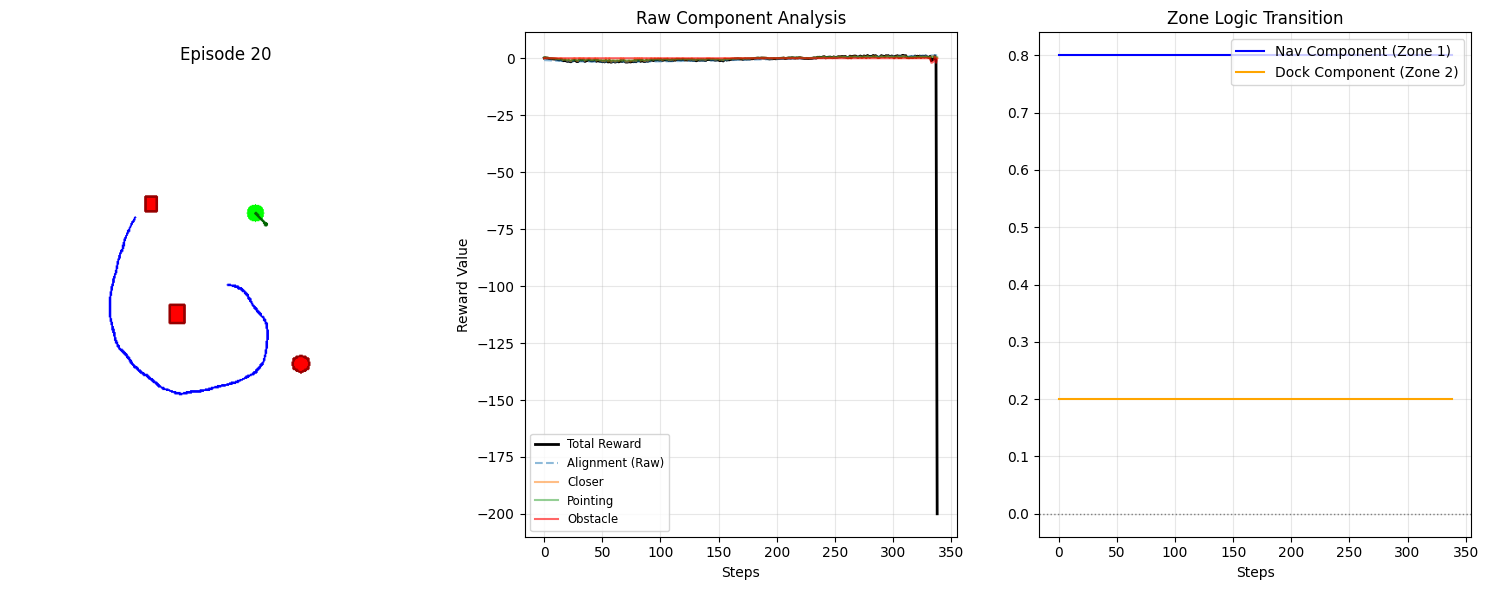

Updating Agent at episode 40...
Ep 40 | Avg Reward: -291.7 | Success Rate: 0.00


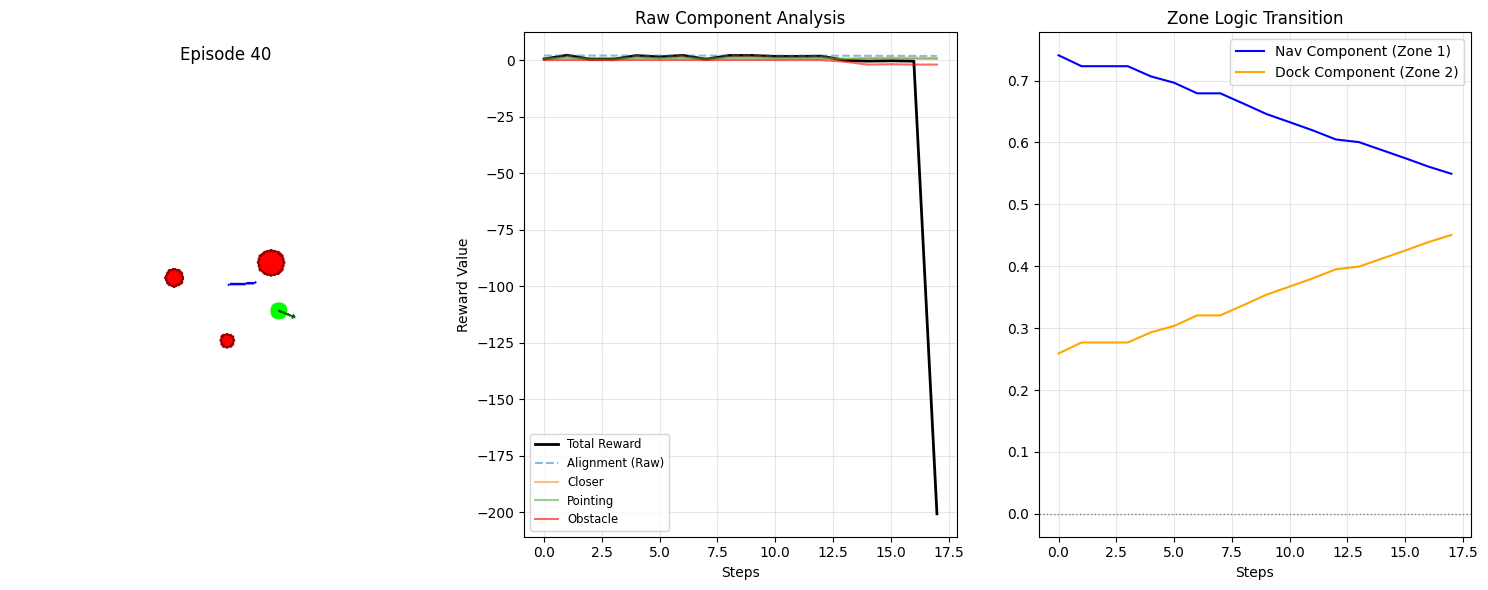

Updating Agent at episode 60...
Ep 60 | Avg Reward: -231.3 | Success Rate: 0.00


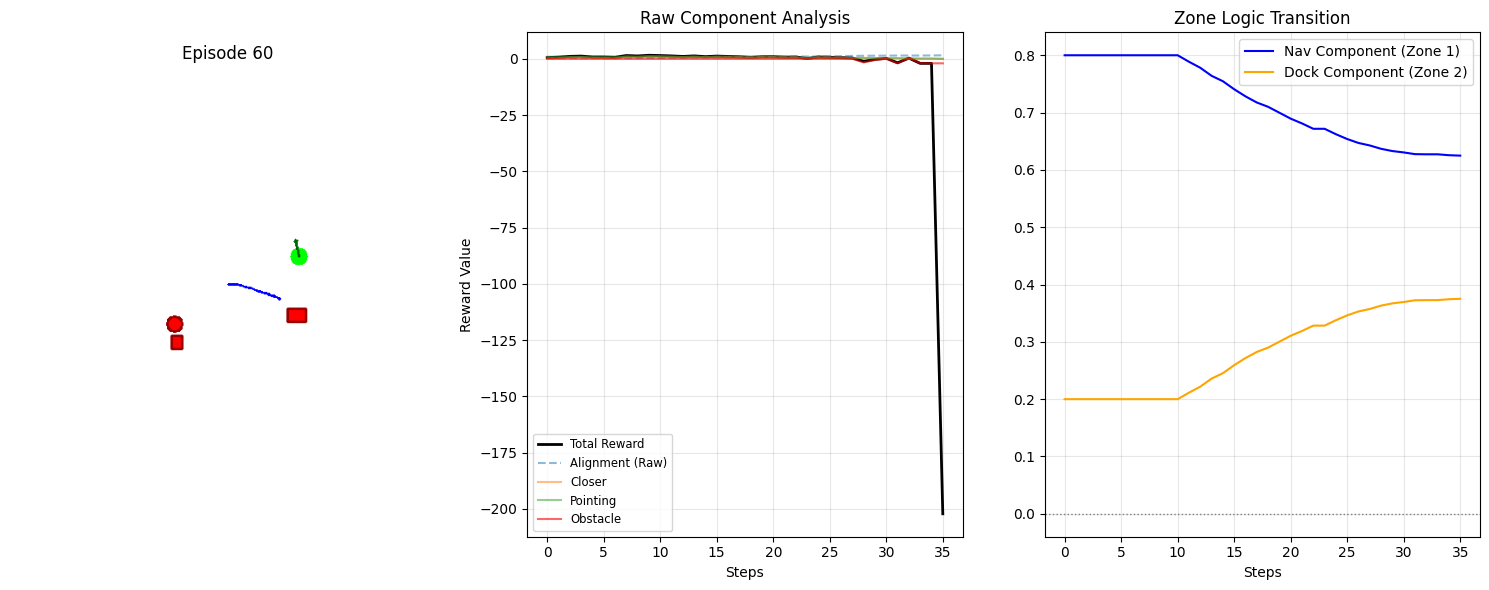

Updating Agent at episode 80...
Ep 80 | Avg Reward: -209.8 | Success Rate: 0.00


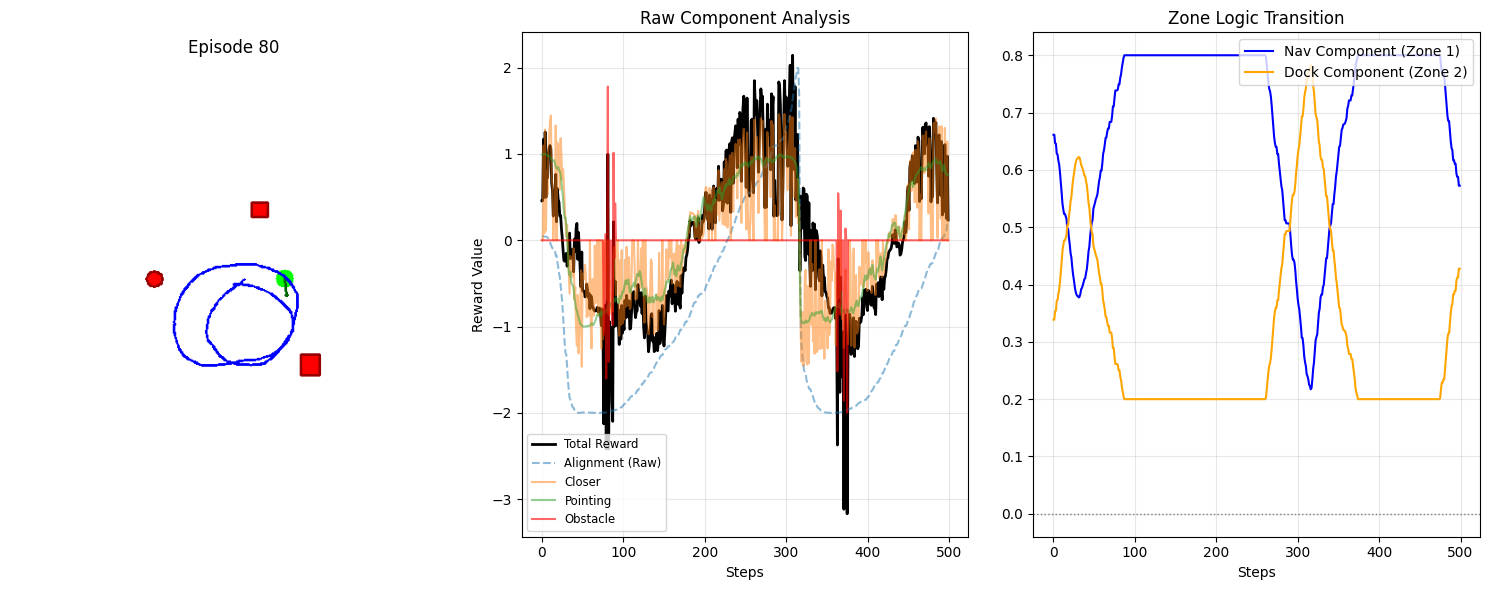

Updating Agent at episode 100...
Ep 100 | Avg Reward: -288.9 | Success Rate: 0.00


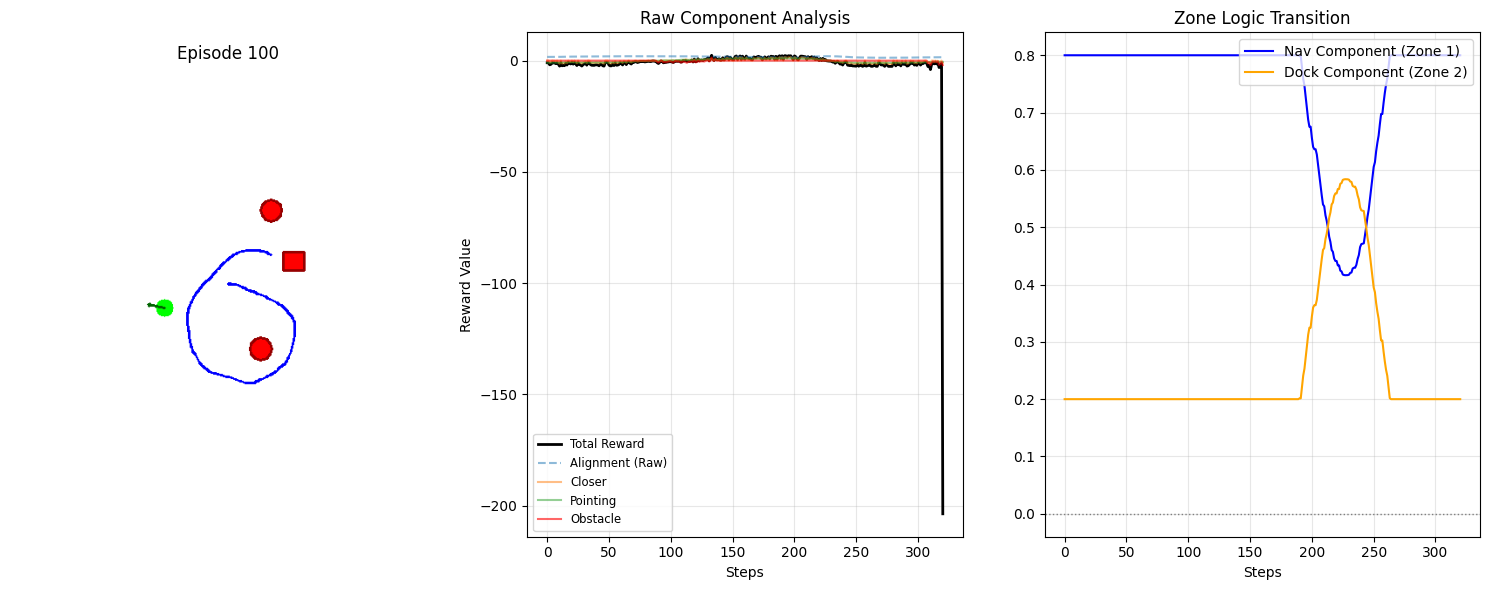

Updating Agent at episode 120...
Ep 120 | Avg Reward: -250.0 | Success Rate: 0.00


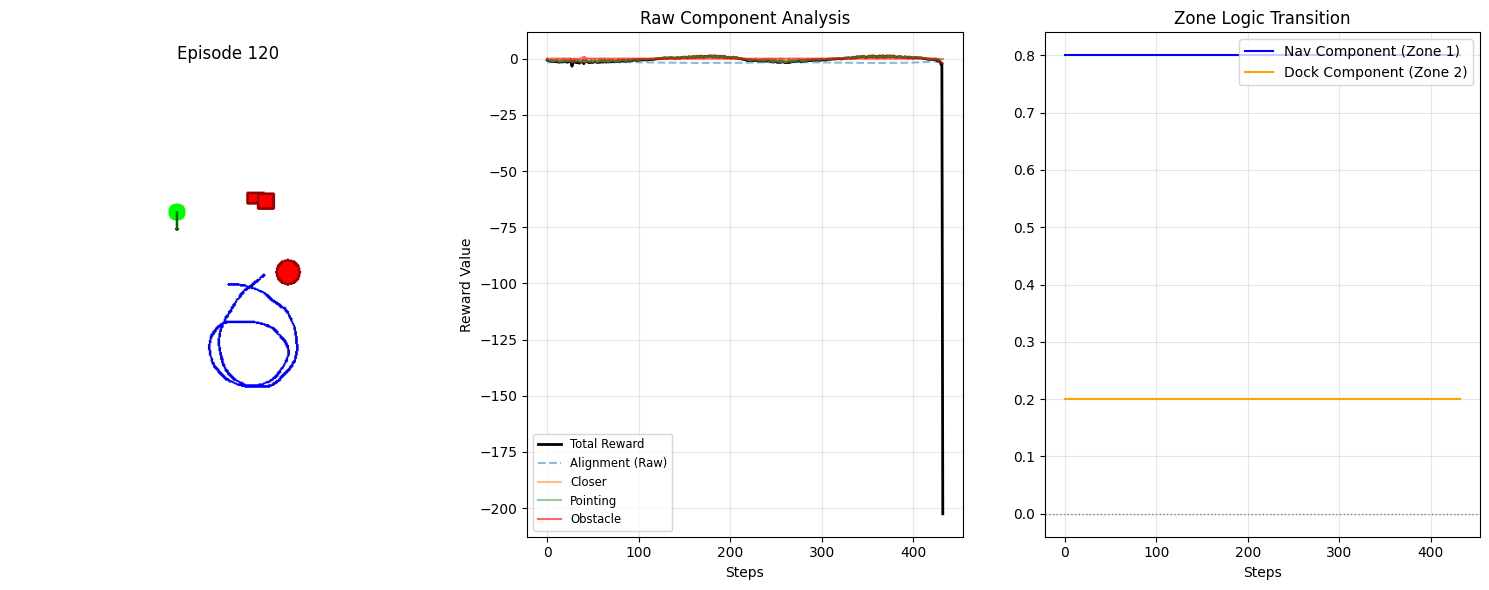

Updating Agent at episode 140...
Ep 140 | Avg Reward: -199.7 | Success Rate: 0.05


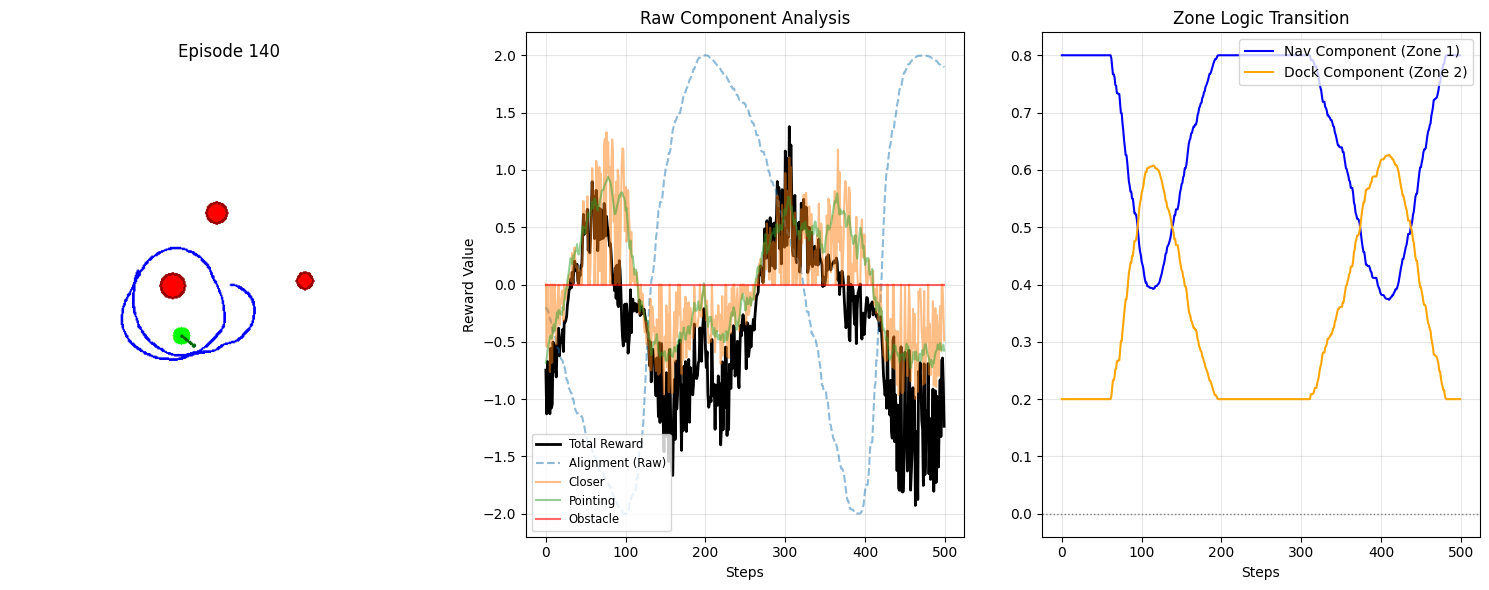

Updating Agent at episode 160...
Ep 160 | Avg Reward: -182.5 | Success Rate: 0.00


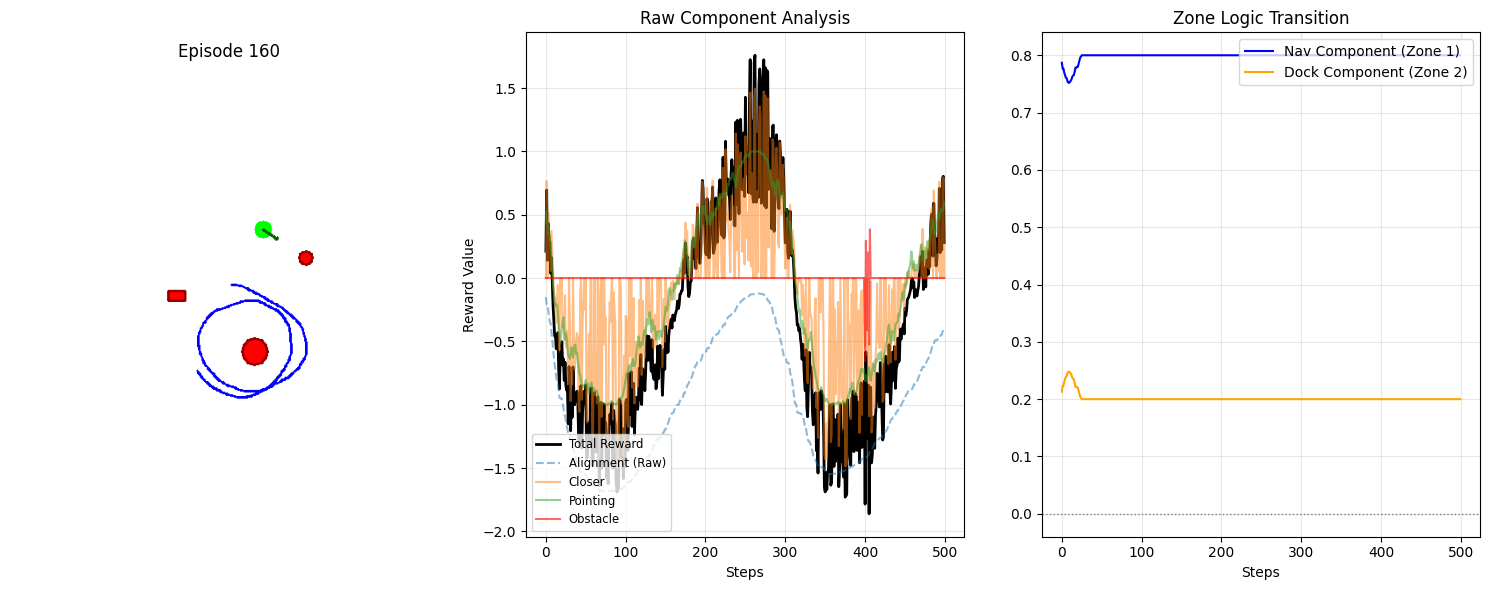

KeyboardInterrupt: 

In [7]:
# --- Training Loop ---
BATCH_SIZE = 20  # Update policy every 20 episodes
MAX_STEPS = 500  
MAX_EPISODES = 1000

print(f"Starting training on {device}...")
reward_history = []     # Log batch for total episode reward and success status 

agent.actor.train()
agent.critic.train()

for episode in range(1, MAX_EPISODES + 1):
    # 1. SETUP EPISODE
    # Each episode is a different enviroment configuration
    seed = sample_seed()
    obs, info = env.reset(seed)

    reward_calculator.reset()

    # --- EPISODE BUFFER (Temporary Storage) ---
    ep_obs = []
    ep_actions = []
    ep_log_probs = []
    ep_rewards = []
    ep_values = []
    
    ep_reward = 0
    trajectory = []
    goal_pose = env.goal
    
    for t in range(MAX_STEPS):
        # 1. Normalize observation
        n_obs = obs_normalizer.normalize(obs)
        n_obs_tensor = torch.FloatTensor(n_obs).to(device)

        # 2. Get Action from Agent
        action, log_prob, val, _ = agent.get_action(n_obs_tensor)
        
        # Clip action for environment (physical limits)
        action_np = action.cpu().numpy()
        action_clipped = np.clip(action_np, -1.0, 1.0) 

        # 3. Step Environment
        new_obs, terminated, truncated, info = env.step(action_clipped)
        
        # 4. Compute Reward
        reward = reward_calculator.compute_reward(obs, action_clipped, info, truncated)
        
        # 5. Store in Episode Buffer
        # We store tensors directly where possible to save conversion time later
        ep_obs.append(n_obs_tensor)
        ep_actions.append(action)
        ep_log_probs.append(log_prob)
        ep_rewards.append(reward)
        ep_values.append(val.item())

        obs = new_obs
        ep_reward += reward
        trajectory.append(env.state.copy())

        if terminated or truncated:
            break
            
    # --- EPISODE FINISHED: Process Data ---

    # 1. Calculate "Bootstrap" value (The value of the state AFTER the last step)
    if terminated:
        last_val = 0
    else:
        # Normalize the last observation
        last_obs_norm = obs_normalizer.normalize(obs)
        last_obs_tensor = torch.FloatTensor(last_obs_norm).to(device)
        
        # Get the value
        last_val = agent.get_value(last_obs_tensor)

    # 2. Compute Returns and Advantages for this episode
    ep_returns = calculate_returns(ep_rewards)
    ep_advantages = calculate_advantages(ep_returns, ep_values)

    # 3. Push processed episode to the Batch Buffer
    buffer.push(
        ep_obs, 
        ep_actions, 
        ep_log_probs, 
        ep_returns, 
        ep_advantages,
        ep_values
    )

    # Logging
    reward_history.append((ep_reward, info.get('is_success', False)))


    # --- UPDATE STEP (Check Batch Size) ---
    if episode % BATCH_SIZE == 0:
        print(f"Updating Agent at episode {episode}...")
        
        # Update using the full batch
        agent.update(buffer)
        
        # Clear the batch buffer
        buffer.reset() 
        
        # Print Stats
        avg_r = np.mean([r[0] for r in reward_history[-BATCH_SIZE:]])
        success_rate = np.mean([r[1] for r in reward_history[-BATCH_SIZE:]])
        print(f"Ep {episode} | Avg Reward: {avg_r:.1f} | Success Rate: {success_rate:.2f}")
        
        plot_training_status(trajectory, goal_pose, episode, env)

### Cell 7: Visualization & Save
Plot the learning curve to verify convergence.

Results will be saved to: /content/drive/MyDrive/final_assignment/outputs/models_saved/experiments/ppo_nav_20260113_171406


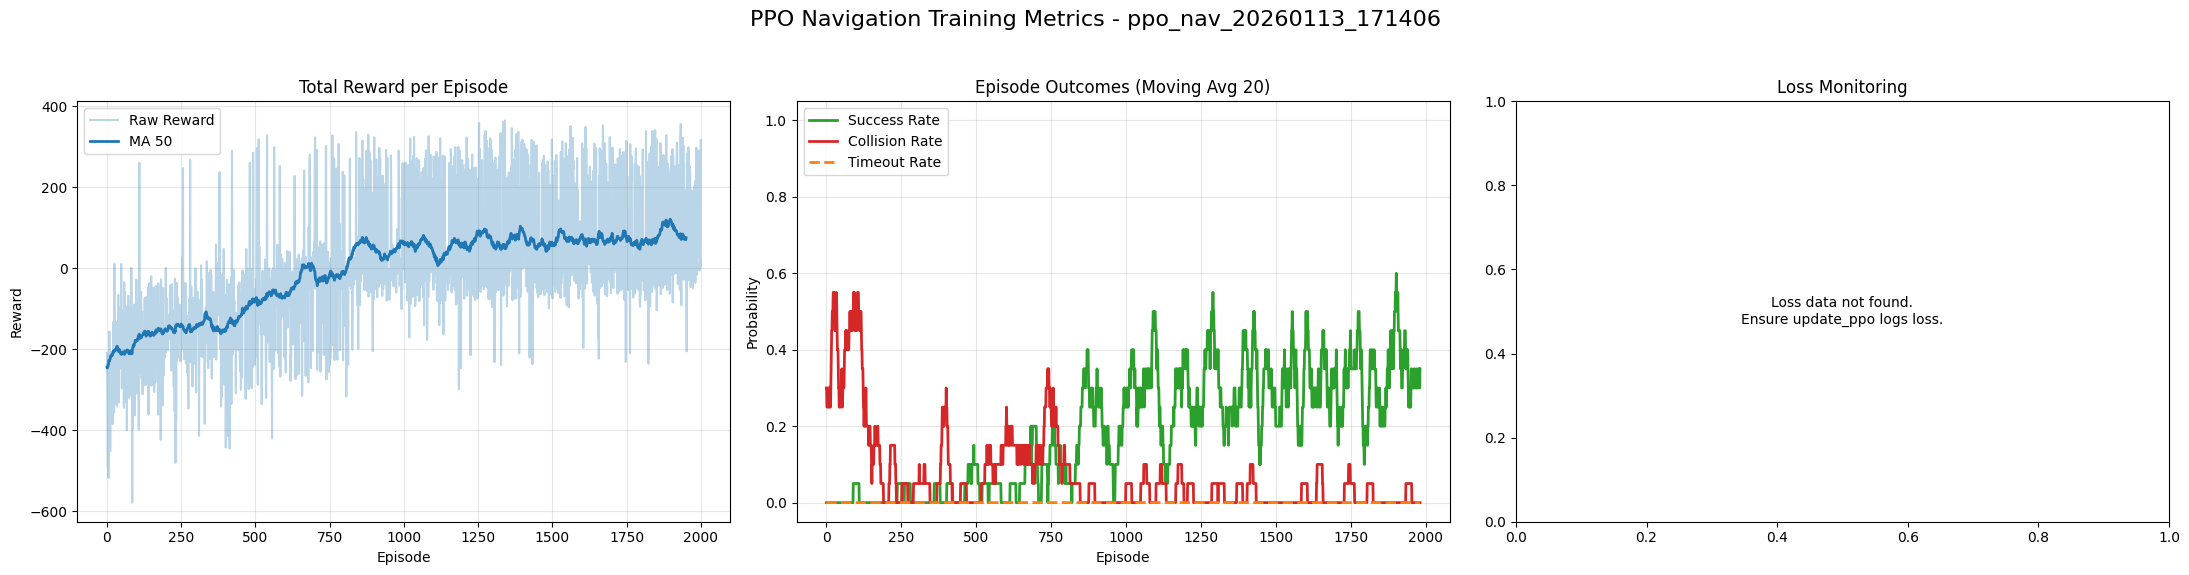

------------------------------
TRAINING SUMMARY SAVED
Final Success Rate (last 20 eps): 35.00%
Model: nav_agent_final.pth
Plots: training_summary.png
------------------------------


In [ ]:
# from google.colab.patches import cv2_imshow # Use this if on Google Colab

def plot_training_status(trajectory, goal, episode_num, env, agent):
    """
    Plots the spatial trajectory, reward components, zone transition, and PPO loss analysis.
    """

    # --- Part A: Render Spatial Trajectory (OpenCV) ---
    height, width = 500, 500
    scale = 50
    center_x, center_y = width // 2, height // 2
    canvas = np.ones((height, width, 3), dtype=np.uint8) * 255
    to_pixel = lambda x, y: (int(center_x + x * scale), int(center_y - y * scale))

    # Draw Obstacles
    for vertices in env.obstacle_manager.get_all_vertices():
        pts = np.array([to_pixel(v[0], v[1]) for v in vertices], dtype=np.int32)
        cv2.fillPoly(canvas, [pts], (0, 0, 255))
        cv2.polylines(canvas, [pts], True, (0, 0, 150), 2)

    # Draw Goal and Heading
    gx, gy = to_pixel(goal[0], goal[1])
    cv2.circle(canvas, (gx, gy), int(0.2 * scale), (0, 255, 0), -1)
    end_gx = gx + int(20 * np.cos(goal[2]))
    end_gy = gy - int(20 * np.sin(goal[2]))
    cv2.arrowedLine(canvas, (gx, gy), (end_gx, end_gy), (0, 100, 0), 2)

    # Draw Path
    if len(trajectory) > 0:
        path_pixels = np.array([to_pixel(pt[0], pt[1]) for pt in trajectory], dtype=np.int32)
        cv2.polylines(canvas, [path_pixels.reshape((-1, 1, 2))], False, (255, 0, 0), 2)
    

     # --- Part B: Plotting with Matplotlib ---
    # Changed to 2x2 Grid to accommodate the Loss Plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # --- PLOT 1: Trajectory Rendering (Top-Left) ---
    ax1 = axs[0, 0]
    ax1.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Episode {episode_num}: Trajectory")
    ax1.axis('off')

    # Get reward history
    hist = reward_calculator.history

    # --- PLOT 2: Raw Reward Analysis (Top-Right) ---
    ax2 = axs[0, 1]
    ax2.plot(hist['total'], label='Total Reward', color='black', linewidth=2)
    ax2.plot(hist['alignment_reward'], label='Alignment (Raw)', alpha=0.5, linestyle='--')
    ax2.plot(hist['closer_reward'], label='Closer', alpha=0.5)
    ax2.plot(hist['pointing_reward'], label='Pointing', alpha=0.5)
    ax2.plot(hist['obstacle_reward'], label='Obstacle', color='red', alpha=0.6)

    ax2.set_title("Raw Reward Components")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Reward Value")
    ax2.legend(loc='lower left', fontsize='x-small')
    ax2.grid(True, alpha=0.3)

    # --- PLOT 3: Zone Transition (Bottom-Left) ---
    ax3 = axs[1, 0]
    ax3.plot(hist['nav_weight'], label='Nav Component (Zone 1)', color='blue')
    ax3.plot(hist['dock_weight'], label='Dock Component (Zone 2)', color='orange')
    ax3.axhline(0, color='grey', linestyle=':', linewidth=1)

    ax3.set_title("Zone Logic Transition")
    ax3.set_xlabel("Steps")
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    # --- PLOT 4: PPO Loss Analysis (Bottom-Right) ---
    ax4 = axs[1, 1]
    
    # Helper to convert potential tensors to cpu floats for plotting
    def extract_data(data_list):
        if not data_list: return []
        if torch.is_tensor(data_list[0]):
            return [x.detach().cpu().item() for x in data_list]
        return data_list

    if len(agent.loss_history) > 0:
        # PPO updates occur less frequently than steps, so x-axis is "Updates"
        total_loss = extract_data(agent.loss_history)
        policy_loss = extract_data(agent.policy_loss_history)
        value_loss = extract_data(agent.value_loss_history)
        entropy = extract_data(agent.entropy_history)

        ax4.plot(total_loss, label='Total Loss', color='black', linewidth=1.5)
        ax4.plot(policy_loss, label='Policy Loss', color='red', alpha=0.6, linestyle='--')
        ax4.plot(value_loss, label='Value Loss (MSE)', color='blue', alpha=0.6, linestyle='--')
        # Entropy is often small, plotting on twinx might be better, but plotting here for overview
        ax4.plot(entropy, label='Entropy', color='green', alpha=0.6, linestyle=':')

        ax4.set_title("PPO Loss Components")
        ax4.set_xlabel("PPO Updates")
        ax4.set_ylabel("Loss Value")
        ax4.legend(loc='upper right', fontsize='x-small')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, "No Training Updates Yet", ha='center', va='center')
        ax4.axis('off')

    plt.tight_layout()
    plt.show()

### Evaluation

In [ ]:
from evaluation.navigation_evaluation import evaluate_single_nav_model, evaluate_single_nav_model_path

model_path = '/content/drive/MyDrive/final_assignment/outputs/models_saved/experiments/ppo_nav_20260113_171406/nav_agent_final.pth'
model_alias = 'Model PPO'
# NB the render = True ti permette di vedere tutti i 50 episodi runnati dall'evaluation. Molto utile per
#    capire come si comporta il modello ( molto piu utile che solo leggere i valori ritornati dall'evaluation )

evaluate_single_nav_model(model_path, model_alias)
evaluate_single_nav_model_path(model_path, model_alias, 50)

🎲 Using Seed: 0
Starting 50 episodes...
Progress: 50/50
Evaluation Complete.

                        NAVIGATION EVALUATION REPORT: MODEL PPO                      
╒══════════╤═══════════════════════╤════════════════╤═════════════════╤═════════════╤══════════════╕
│ Metric   │ Value                 │ Metric         │ Value           │ Metric      │ Value        │
╞══════════╪═══════════════════════╪════════════════╪═════════════════╪═════════════╪══════════════╡
│ Status   │ ❌ POOR (100.0% Fail) │ Success Rate   │ 0.0 %           │ Mean Steps  │ 1000.0 ± 0.0 │
├──────────┼───────────────────────┼────────────────┼─────────────────┼─────────────┼──────────────┤
│ Model    │ Model PPO             │ Collision Rate │ 0.0 %           │ Avg Energy  │ 52.52 ± 2.69 │
├──────────┼───────────────────────┼────────────────┼─────────────────┼─────────────┼──────────────┤
│ Date     │ 2026-01-13 17:33      │ Safety Margin  │ 1.195 ± 0.258 m │ Path Lenght │ 0.00 ± 0.00  │
╘══════════╧═════════════════

FileNotFoundError: [Errno 2] No such file or directory: 'configs/empty_env.yaml'

### Cell 8: ⚠ Delete the train directory ( only for bed results )

In [ ]:
import shutil

# --- DELETE CURRENT EXPERIMENT DIRECTORY ---
# Ask for confirmation to prevent accidental deletion
confirm = input(f"Do you want to delete the directory '{run_id}'? (y/n): ")

if confirm.lower() == 'y':
    try:
        # shutil.rmtree deletes a directory and all its contents
        shutil.rmtree(output_dir)
        print(f"Successfully deleted: {output_dir}")
    except OSError as e:
        print(f"Error: {e.strerror}. Could not delete the directory.")
else:
    print("Deletion cancelled. Experiment results preserved.")